In [ ]:
!unzip "/content/drive/MyDrive/Dataset/pestOutput_model.zip" -d "/content/drive/MyDrive/Dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_2.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_20.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_200.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_201.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_202.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_203.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_204.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_205.jpg  
  inflating: /content/drive/MyDrive/Dataset/pestOutput_model/train/caterpillar/caterpillar_206.jpg  
  inflating: /content/drive/MyDrive/Dataset

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2
import numpy as np
from sklearn import svm
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, AveragePooling2D
from sklearn.metrics import confusion_matrix

import os
import shutil

In [ ]:
# Define the image size
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)

# Define the batch size for training
batch_size = 32
# batch_size = 16

In [ ]:
# Define the paths to the dataset
path_train_test_val = "/content/drive/MyDrive/Dataset/pestOutput_model/"
train_path = path_train_test_val + 'train'
test_path = path_train_test_val + 'test'
val_path = path_train_test_val + 'valid'

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=40,
                                   brightness_range=[0.4,1.5],
                                   rescale = 1./255,
                                   fill_mode='nearest'
                                   )

# Training data
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(img_width, img_height),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',)


# experiment - rotation_range: 40

Found 4200 images belonging to 6 classes.


In [ ]:
val_datagen = ImageDataGenerator(rotation_range=40,
                                brightness_range=[0.4,1.5],
                                rescale = 1./255,
                                fill_mode='nearest')

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size=(img_width, img_height),
                                                color_mode="rgb",
                                                batch_size=batch_size,
                                                class_mode='categorical',)

# train, val - should have same arugments (generally)

Found 900 images belonging to 6 classes.


In [ ]:
# Test dataset
# test_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  brightness_range=[0.4,1.5],
                                  fill_mode='nearest')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(img_width, img_height),
                                                  color_mode="rgb",
                                                  batch_size=batch_size,
                                                  class_mode='categorical')


Found 900 images belonging to 6 classes.


In [ ]:
train_generator.class_indices.keys()

dict_keys(['caterpillar', 'healthy', 'insects', 'leaves only', 'nematode', 'snails'])

In [ ]:
num_classes = len(train_generator.class_indices.keys())
num_classes

6

In [ ]:
# Define the model architecture
model = keras.models.Sequential()

# Add the first convolutional layer
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolutional layer
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output before passing it to the fully connected layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 conv2d_3 (Conv2D)           (None, 252, 252, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 16)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                16257088  
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                      

In [ ]:
import tensorflow as tf

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.AdamW(),
              metrics=["accuracy"])

In [ ]:
from keras.callbacks import TensorBoard

# save the weights and the model in directory
save_dir = "/content/drive/MyDrive/Dataset/modelPest/"

checkpoint = ModelCheckpoint(save_dir+'cnn_med_16_2.h5',
                             save_best_only = True,
                             verbose = 1)

early_stopping = keras.callbacks.EarlyStopping(patience=5,
                                               monitor='val_loss',
                                               restore_best_weights=True)

save_dir_tb = save_dir + "/my_logs/fit/cnn_med_16_2"
tensorboard_callback = TensorBoard(log_dir=save_dir_tb)

In [ ]:
epochs = 1000

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpoint, early_stopping, tensorboard_callback],
                    )

Epoch 1/1000
132/132 [==============================] - ETA: 0s - loss: 2.6834 - accuracy: 0.3679
Epoch 1: val_loss improved from inf to 1.25483, saving model to /content/drive/MyDrive/Dataset/modelPest/cnn_med_16_2.h5
132/132 [==============================] - 117s 863ms/step - loss: 2.6834 - accuracy: 0.3679 - val_loss: 1.2548 - val_accuracy: 0.5322
Epoch 2/1000
132/132 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.6519
Epoch 2: val_loss improved from 1.25483 to 0.83119, saving model to /content/drive/MyDrive/Dataset/modelPest/cnn_med_16_2.h5
132/132 [==============================] - 114s 859ms/step - loss: 0.9507 - accuracy: 0.6519 - val_loss: 0.8312 - val_accuracy: 0.7367
Epoch 3/1000
132/132 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.7810
Epoch 3: val_loss improved from 0.83119 to 0.58627, saving model to /content/drive/MyDrive/Dataset/modelPest/cnn_med_16_2.h5
132/132 [==============================] - 114s 859ms/step - loss

In [ ]:
# Rollback to the best performing model
save_dir = "/content/drive/MyDrive/Dataset/modelPest/"

model = keras.models.load_model(save_dir + 'cnn_med_16_2.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 conv2d_3 (Conv2D)           (None, 252, 252, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 16)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                16257088  
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                      

In [ ]:
accuracy_score = model.evaluate(test_generator)

print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ", accuracy_score[0])

29/29 [==============================] - 21s 714ms/step - loss: 0.3049 - accuracy: 0.9522
Accuracy: 95.2222%
Loss:  0.30486440658569336


In [ ]:
# # RESUME TRAINING HERE
# # In case the training is interrupted in between - load the model,
# # then resume training from here

# from keras.callbacks import TensorBoard

# epochs = 1000

# save_dir = "/content/drive/MyDrive/Dataset/modelPest/"

# ### !!! REMEMBER TO CHANGE HERE
# checkpoint = ModelCheckpoint(save_dir+'network_16.h5',
#                              save_best_only = True,
#                              verbose = 1)

# early_stopping = keras.callbacks.EarlyStopping(patience=5,
#                                                monitor='val_loss',
#                                                restore_best_weights=True)


# save_dir_tb = save_dir + "/my_logs/fit/network_16"
# tensorboard_callback = TensorBoard(log_dir=save_dir_tb)

# # load the checkpoint and resume training from here
# ### !!! change initial_epoch
# history = model.fit(train_generator,
#                     validation_data=val_generator,
#                     epochs=epochs,
#                     callbacks = [checkpoint, early_stopping, tensorboard_callback],
#                     initial_epoch=25,
#                     )

Activation Visualisations

1/1 [==============================] - 8s 8s/step
Convolution Layer - 1


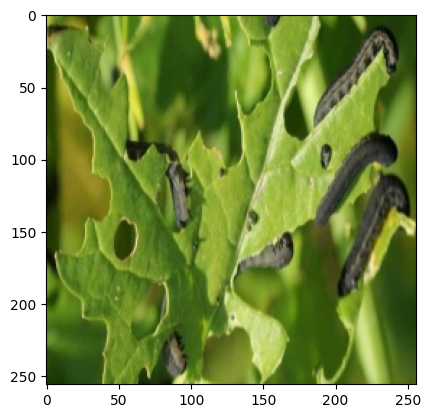

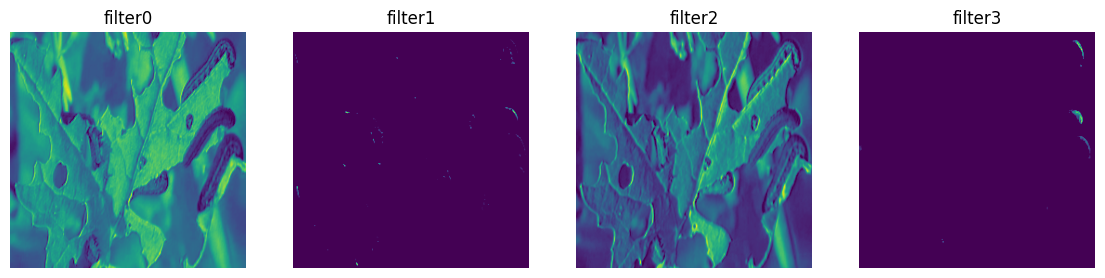

In [ ]:
img = load_img('/content/drive/MyDrive/Dataset/pestOutput_model/train/insects/insects_20.jpg',
               target_size=(img_width,img_height))
plt.imshow(img);
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)


# creating a layer object
conv2d_2_output = Model(inputs = model.input,
                         outputs = model.get_layer('conv2d_2').output)
conv2d_2_features = conv2d_2_output.predict(img)

fig = plt.figure(figsize = (14,7))
columns = 4
rows = 1

print("Convolution Layer - 1")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_2_features[0, :, :, i], cmap = 'viridis')
plt.show()

1/1 [==============================] - 0s 123ms/step
Convolution Layer - 2


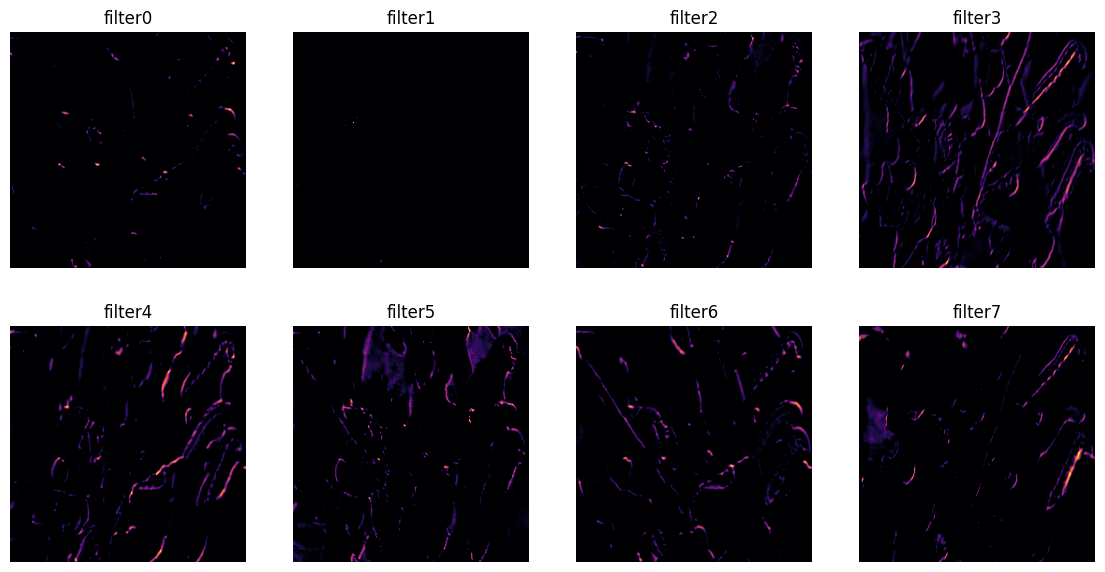

In [ ]:
# creating a layer object
conv2d_3_output = Model(inputs = model.input,
                         outputs = model.get_layer('conv2d_3').output)
conv2d_3_features = conv2d_3_output.predict(img)

fig = plt.figure(figsize = (14,7))
columns = 4
rows = 2

print("Convolution Layer - 2")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_3_features[0, :, :, i], cmap='inferno')
plt.show()

In [ ]:
from matplotlib import colormaps
list(colormaps)

In [ ]:
from keras.models import Model

X_batch, _ = next(train_generator)

In [ ]:
def visualize_CAMs(layer_name, rows, columns, X_batch):
    # creating a layer object
    conv2d_3_output = Model(inputs = model.input,
                            outputs = model.get_layer('conv2d_1').output)
    conv2d_3_features = conv2d_3_output.predict(X_batch)

    fig = plt.figure(figsize = (14,7))

    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title('filter' + str(i))
        plt.imshow(conv2d_3_features[0, :, :, i], cmap='inferno')
    plt.show()

1/1 [==============================] - 0s 62ms/step


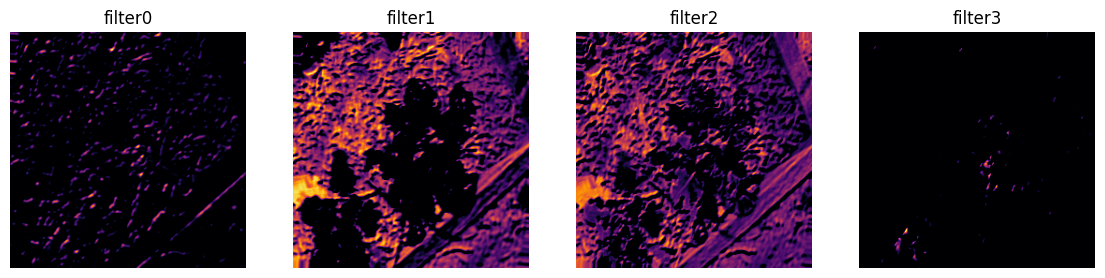

In [ ]:
visualize_CAMs('conv2d', 1, 4, X_batch)

1/1 [==============================] - 0s 374ms/step


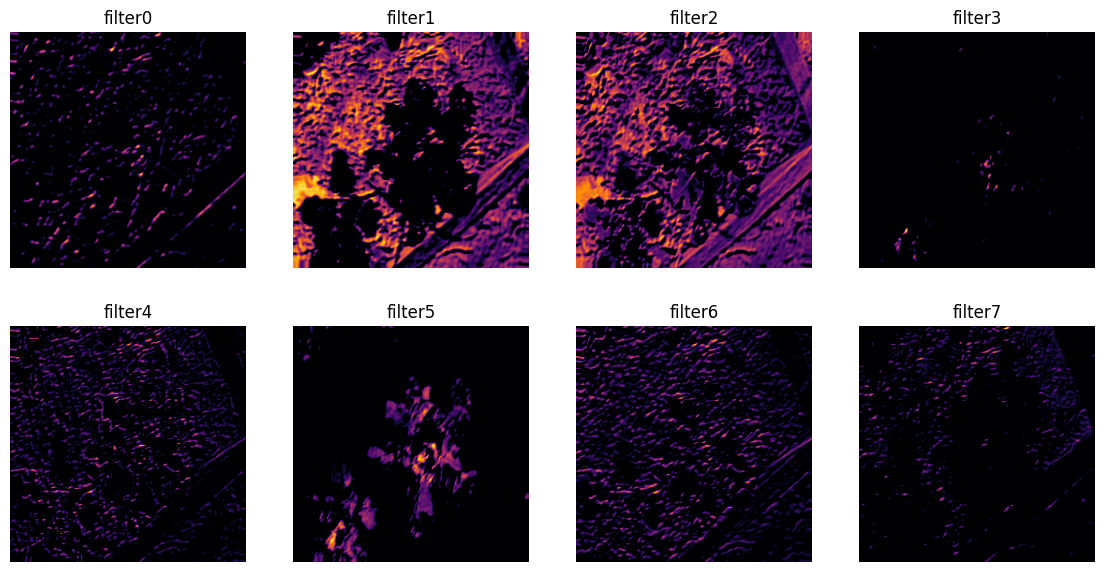

In [ ]:
visualize_CAMs('conv2d_1', 2, 4, X_batch)

1/1 [==============================] - 0s 57ms/step


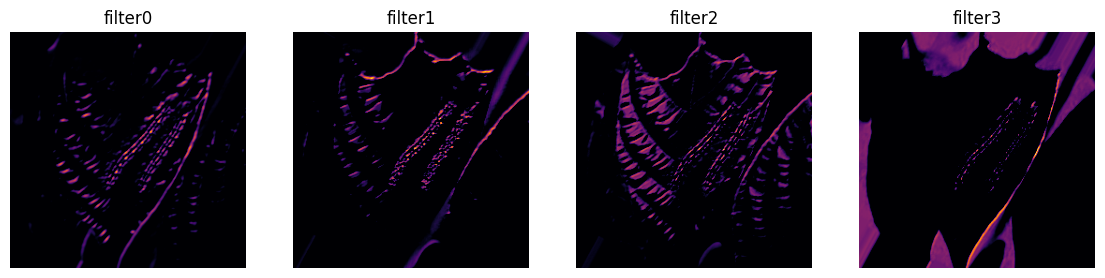

In [ ]:
visualize_CAMs('conv2d', 1, 4, X_batch)

1/1 [==============================] - 0s 63ms/step


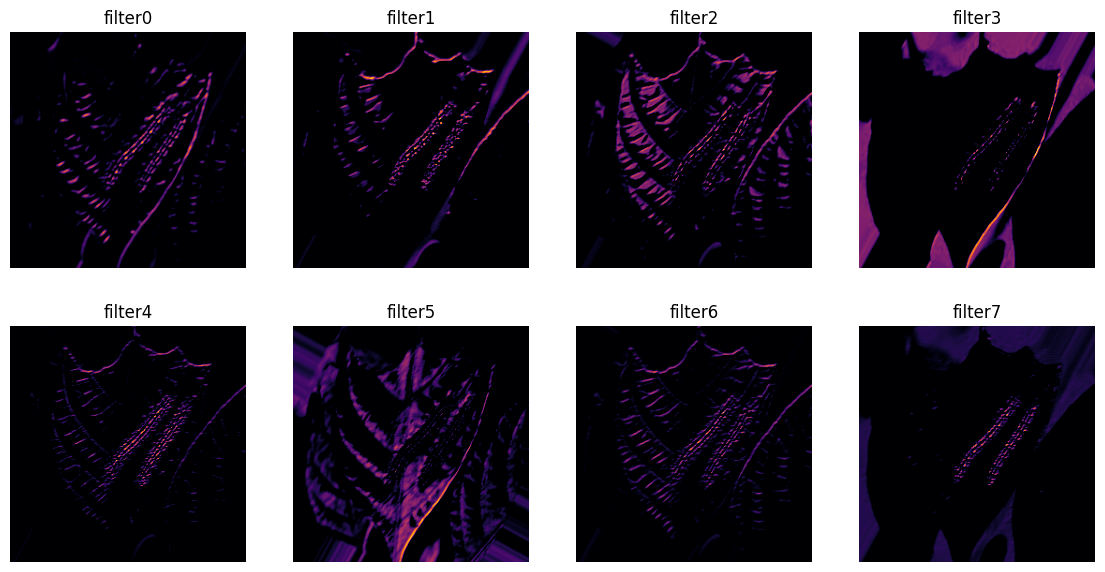

In [ ]:
visualize_CAMs('conv2d_1', 2, 4, X_batch)

1/1 [==============================] - 0s 54ms/step


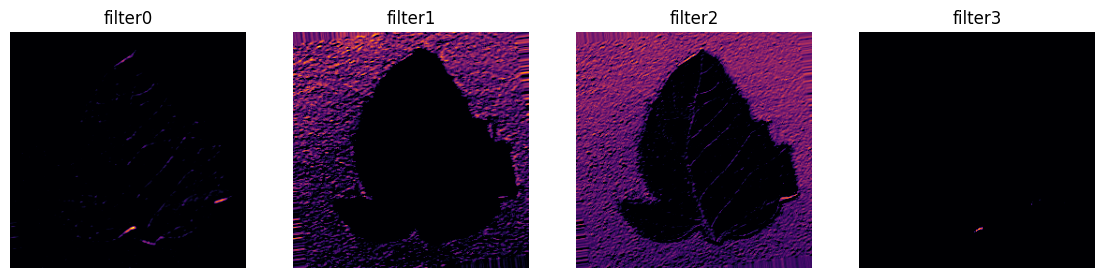

In [ ]:
visualize_CAMs('conv2d', 1, 4, X_batch)

1/1 [==============================] - 0s 61ms/step


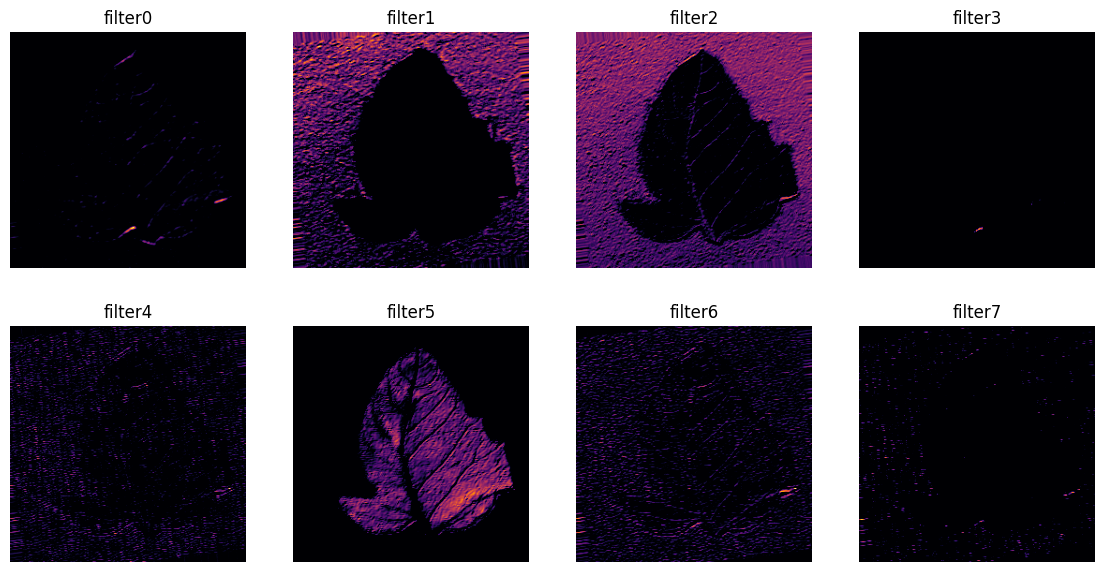

In [ ]:
visualize_CAMs('conv2d_1', 2, 4, X_batch)

Predicting on new images

In [ ]:
class_labels = train_generator.class_indices

# class_labels is a dictionary where the keys are class labels and values are corresponding indices
# For example: {'class_1': 0, 'class_2': 1, 'class_3': 2, ...}

print("class_labels: ", class_labels)

class_labels:  {'caterpillar': 0, 'healthy': 1, 'insects': 2, 'leaves only': 3, 'nematode': 4, 'snails': 5}


In [ ]:
num_classes = len(train_generator.class_indices.keys())
print(num_classes)

li = list(class_labels.keys())
li

6


['caterpillar', 'healthy', 'insects', 'leaves only', 'nematode', 'snails']

In [ ]:
from keras.utils import load_img
from tensorflow.keras.preprocessing import image

def predict_function(file_name):
    # print("class_labels: ", class_labels)

    image_path = "/content/"+file_name
    new_img = load_img(image_path, target_size=(img_width,img_height))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    # print("Image shape (batch_size, img_widgth, img_height, rgb) : ", img.shape)
    # prediction = [[0]]
    prediction = model.predict(img)
    # img_class = classifier.predict(img)
    predict_classes = np.argmax(prediction,axis=1)
    # print("\nModel probabilities belonging to each: \n", prediction[0]) # [0]
    # print("\nClass predicted [argmax]: ", predict_classes)

    d = prediction.flatten()
    j = d.max()

    class_name = None
    for index,item in enumerate(d):
        if item == j:
            class_name = li[index]

    #ploting image with predicted class name
    plt.figure(figsize = (2,2))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title("Real: "+file_name[:-4]+"\nPredicted: "+class_name)
    plt.show()

    # print("\n\n-----------------------------------------------------------------------\n")

1/1 [==============================] - 0s 26ms/step


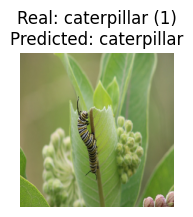

1/1 [==============================] - 0s 63ms/step


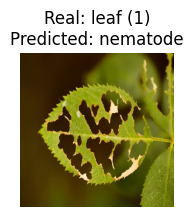

1/1 [==============================] - 0s 24ms/step


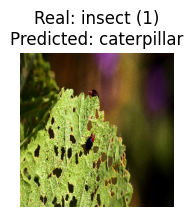

1/1 [==============================] - 0s 33ms/step


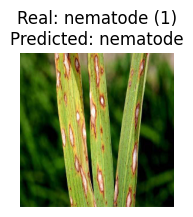

1/1 [==============================] - 0s 42ms/step


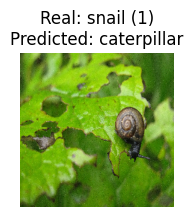

1/1 [==============================] - 0s 28ms/step


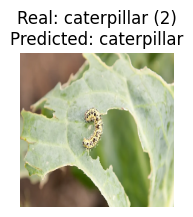

1/1 [==============================] - 0s 28ms/step


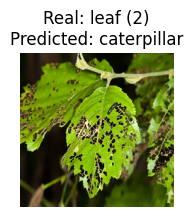

1/1 [==============================] - 0s 42ms/step


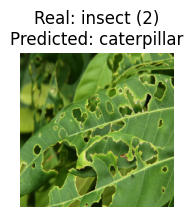

1/1 [==============================] - 0s 41ms/step


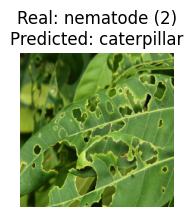

1/1 [==============================] - 0s 33ms/step


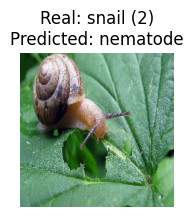

1/1 [==============================] - 0s 31ms/step


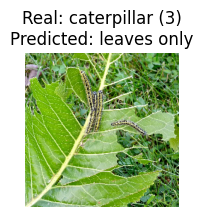

1/1 [==============================] - 0s 25ms/step


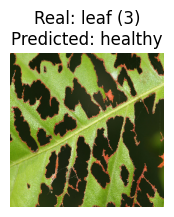

1/1 [==============================] - 0s 25ms/step


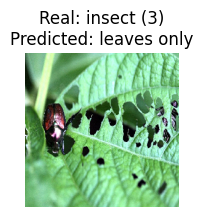

1/1 [==============================] - 0s 94ms/step


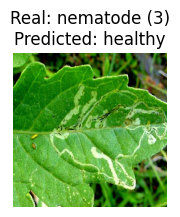

1/1 [==============================] - 0s 17ms/step


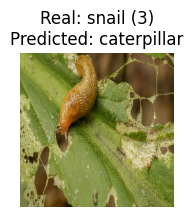

1/1 [==============================] - 0s 17ms/step


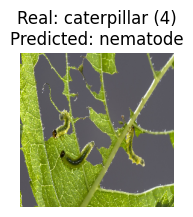

1/1 [==============================] - 0s 17ms/step


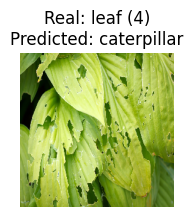

1/1 [==============================] - 0s 19ms/step


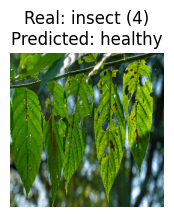

1/1 [==============================] - 0s 19ms/step


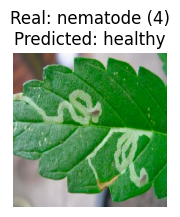

1/1 [==============================] - 0s 19ms/step


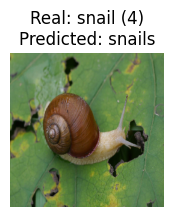

In [ ]:
# image_list = ['caterpillar (1).jpg', 'caterpillar (2).jpg', 'caterpillar (3).jpg', 'caterpillar (4).jpg', 'caterpillar (5).jpg',
#               'insect (1).jpg', 'insect (2).jpg', 'insect (3).jpg', 'insect (4).jpg', 'insect (5).jpg',
#               'leaf (1).jpg', 'leaf (2).jpg', 'leaf (3).jpg', 'leaf (4).jpg', 'leaf (5).jpg',
#               'nematode (1).jpg', 'nematode (2).jpg', 'nematode (3).jpg', 'nematode (4).jpg', 'nematode (5).jpg',
#               'snail (1).jpg', 'snail (2).jpg', 'snail (3).jpg', 'snail (4).jpg', 'snail (5).jpg', ]

image_list = ['caterpillar (1).jpg', 'caterpillar (2).jpg', 'caterpillar (3).jpg', 'caterpillar (4).jpg',
              'insect (1).jpg', 'insect (2).jpg', 'insect (3).jpg', 'insect (4).jpg',
              'leaf (1).jpg', 'leaf (2).jpg', 'leaf (3).jpg', 'leaf (4).jpg',
              'nematode (1).jpg', 'nematode (2).jpg', 'nematode (3).jpg', 'nematode (4).jpg',
              'snail (1).jpg', 'snail (2).jpg', 'snail (3).jpg', 'snail (4).jpg'
              ]

for i in range(1, 5):
    predict_function('caterpillar ({}).jpg'.format(i))
    predict_function('leaf ({}).jpg'.format(i))
    predict_function('insect ({}).jpg'.format(i))
    predict_function('nematode ({}).jpg'.format(i))
    predict_function('snail ({}).jpg'.format(i))

### Keras Documentation: Visualizing what Convnets learn

https://keras.io/examples/vision/visualizing_what_convnets_learn/

Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv3_block4_out"

Build a feature extraction model

In [ ]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

94668760/94668760 [==============================] - 5s 0us/step


Set up the gradient ascent process

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

Set up the end-to-end filter visualization loop

In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.utils.save_img("0.png", img)

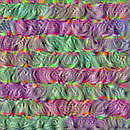

In [ ]:
display(Image("0.png"))

Visualize the first 64 filters in the target layer

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

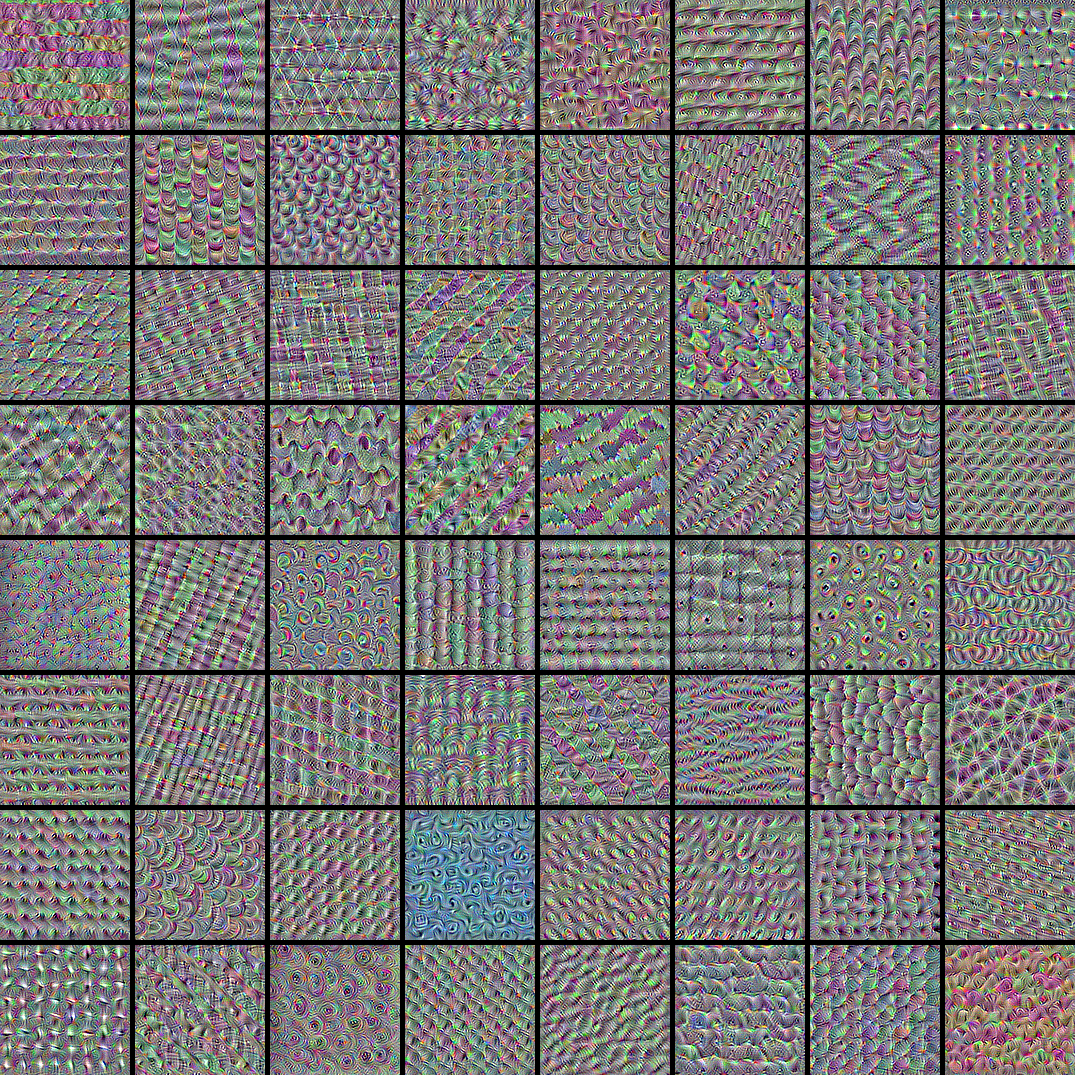

In [ ]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.utils.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))